## Using Linear models (from `sklearn.linear_model`) on crypto price trend prediction

In [2]:
# Preliminary code needed for importing from parent directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

# Import Karan's data API
from data import series

import numpy as np

# This classifier first converts the target values into {-1, 1} and then treats the problem as a regression task
# (multi-output regression in the multiclass case).
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Define a function to generate X, y from raw data (Use Karan's data API)

In [3]:
def gen_X_y(symbol: str, timeframe: str):
    # Create a series for BTC-USDT pair on 1h candles
    # btc = series.DataSeries('BTCUSDT', '1h')
    btc = series.DataSeries(symbol, timeframe)
    data = btc.getData()
    # print(data.keys())

    price_close = data['close']
    # print(len(price_close))
    
    prev5 = np.concatenate([
            # pivot timeframe
            price_close[np.newaxis, 5:],
            # previous 5 timeframes
            price_close[np.newaxis, 4:-1], # 1 frame ago
            price_close[np.newaxis, 3:-2], # 2 frame ago
            price_close[np.newaxis, 2:-3], # 3 frame ago
            price_close[np.newaxis, 1:-4], # 4 frame ago
            price_close[np.newaxis, :-5],  # 5 frame ago
        ],
        axis = 0
    )

    # Generate truth values (y)
    y = prev5[0, :] > np.amin(prev5[1:, :], axis = 0)
    print('timeframe:', timeframe)
    print('number of times where trend is up: ', y[y == True].shape)
    print('number of times where trend is down: ', y[y == False].shape)
    
    btc.addIndicator('RSI', data['close'], 30) # 30-timeframe RSI

    btc.addIndicator('EMA', data['close'], 30) # 30-timeframe EMA
    # btc1h.addIndicator('EMA', btc1h.getData()['close'], 50) # 50-timeframe EMA

    ## MFI: https://www.investopedia.com/terms/m/mfi.asp
    btc.addIndicator('MFI', data['high'], data['low'], data['close'], data['volume'], 10) # 10-timeframe MFI

    ## MACD: https://www.investopedia.com/terms/m/macd.asp
    btc.addIndicator('MACD', data['close'], 12, 26) # fast = 12, slow = 26

    indicators = btc.getIndicators()
    #for indicator in indicators.keys():
        #print(indicator)
        
    time_cut = 50

    # Each technical indicator consists one column of X.
    X = np.concatenate(
        (
            indicators['RSI'][np.newaxis, time_cut:].T,
            indicators['EMA'][np.newaxis, time_cut:].T,
            indicators['MFI'][np.newaxis, time_cut:].T
        ),
        axis = 1
    )
    # print('shape of X:', X.shape)
    # print('shape of y:', y.shape)

    y_truncate = y[(time_cut - 5):]
    
    return (X, y_truncate)

## Generate X, y from 1h-scale data

In [4]:
X_h, y_h = gen_X_y('BTCUSDT', '1h')

# Split train/test sets
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_h, y_h)
print('X, y generated from 1h-scale data')
print('train set size:', y_train_h.shape)
print('test set size:', y_test_h.shape)

timeframe: 1h
number of times where trend is up:  (24655,)
number of times where trend is down:  (6013,)
X, y generated from 1h-scale data
train set size: (22967,)
test set size: (7656,)


## Generate X, y from 1d-scale data

In [5]:
X_d, y_d = gen_X_y('BTCUSDT', '1d')

# Split train/test sets
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d)
print('X, y generated from 1d-scale data')
print('train set size:', y_train_d.shape)
print('test set size:', y_test_d.shape)

timeframe: 1d
number of times where trend is up:  (1039,)
number of times where trend is down:  (239,)
X, y generated from 1d-scale data
train set size: (924,)
test set size: (309,)


## Ridge Classifier

Accuracy of Ridge Classifier (on 1h-scale data)
training set accuracy: 0.8049810597814255
test set accuracy: 0.8070794148380356


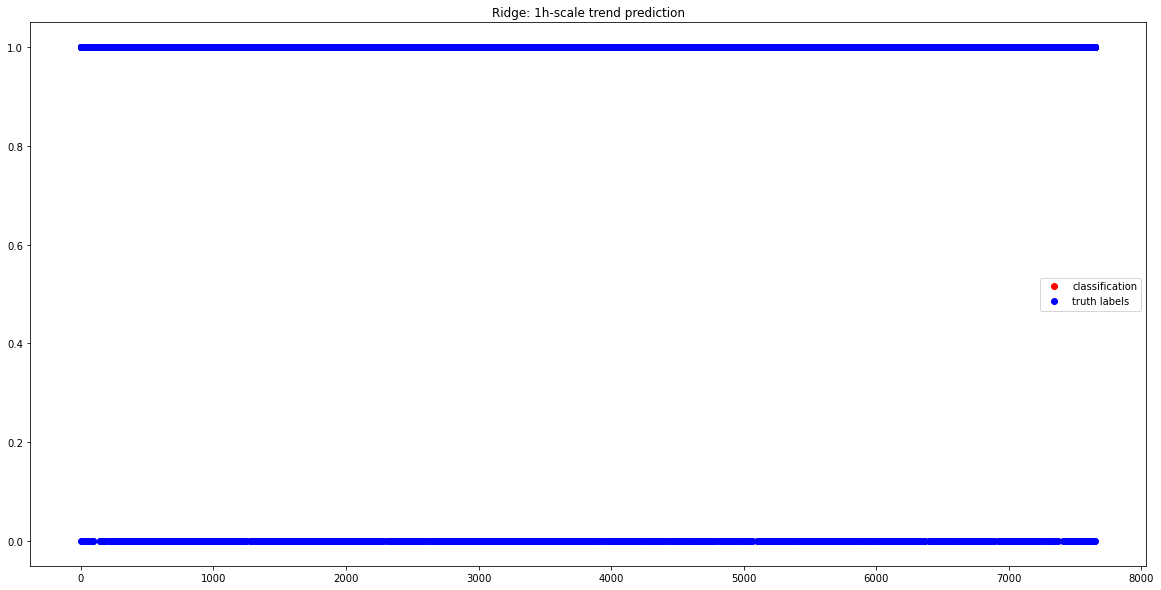

In [20]:
ridge_clf_h = RidgeClassifier().fit(X_train_h, y_train_h)

print('Accuracy of Ridge Classifier (on 1h-scale data)')
print('training set accuracy:', ridge_clf_h.score(X_train_h, y_train_h))
print('test set accuracy:', ridge_clf_h.score(X_test_h, y_test_h))
# print('test set accuracy:', accuracy_score(y_test_h, ridge_clf.predict(X_test_h))) # Exact same result as above
plt.figure(figsize=(20,10))
plt.plot(np.arange(X_test_h.shape[0]), ridge_clf_h.predict(X_test_h), 'ro', label = "classification")
plt.plot(np.arange(X_test_h.shape[0]), y_test_h, 'bo', label = "truth labels")
plt.title('Ridge: 1h-scale trend prediction')
plt.legend()
plt.show()

Accuracy of Ridge Classifier (on 1d-scale data)
training set accuracy: 0.8138528138528138
test set accuracy: 0.8058252427184466


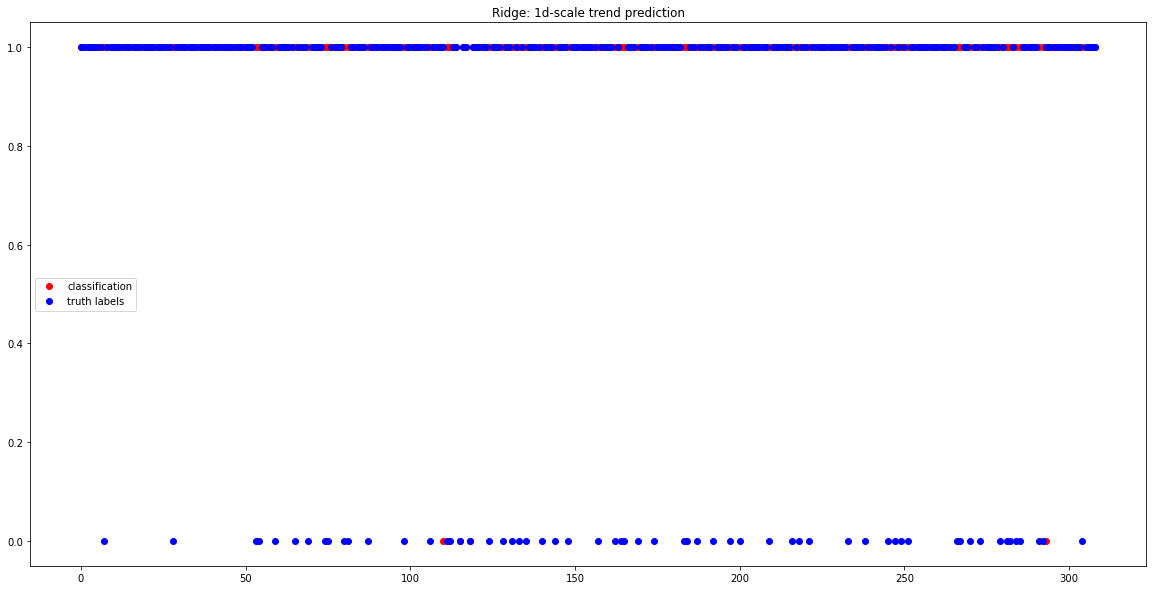

In [21]:
ridge_clf_d = RidgeClassifier().fit(X_train_d, y_train_d)

print('Accuracy of Ridge Classifier (on 1d-scale data)')
print('training set accuracy:', ridge_clf_d.score(X_train_d, y_train_d))
print('test set accuracy:', ridge_clf_d.score(X_test_d, y_test_d))

plt.figure(figsize=(20,10))
plt.plot(np.arange(X_test_d.shape[0]), ridge_clf_d.predict(X_test_d), 'ro', label = "classification")
plt.plot(np.arange(X_test_d.shape[0]), y_test_d, 'bo', label = "truth labels")
plt.title('Ridge: 1d-scale trend prediction')
plt.legend()
plt.show()

## Logistic Regression

Accuracy of Logistic Regression (on 1h-scale data)
training set accuracy: 0.8058518744285279
test set accuracy: 0.8073406478578893


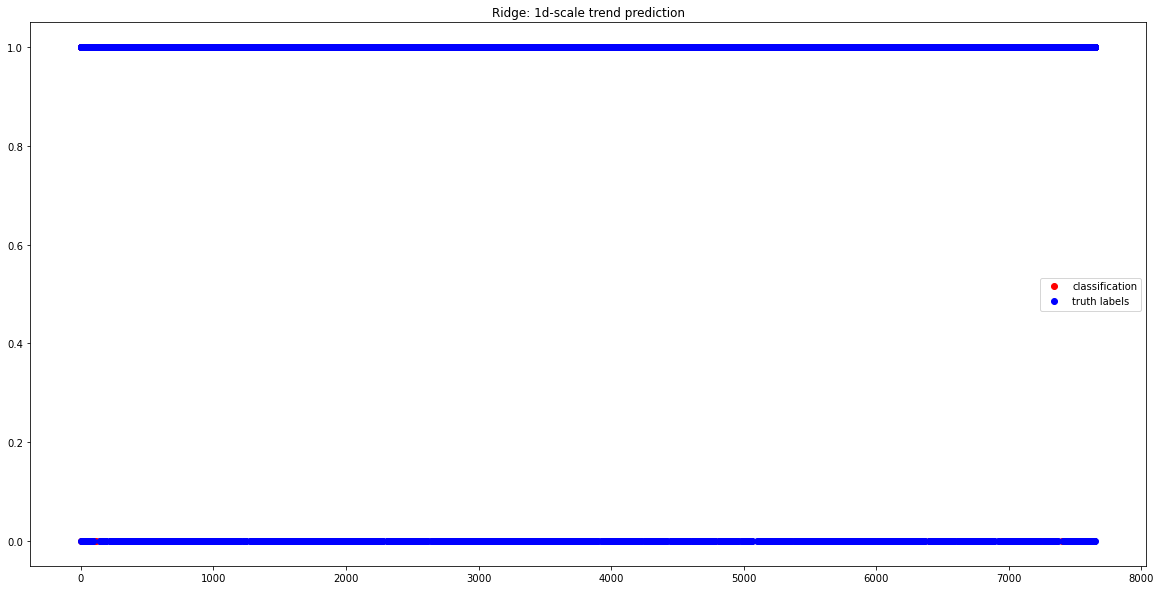

In [22]:
logi_clf_h = LogisticRegression(random_state=0).fit(X_train_h, y_train_h)

print('Accuracy of Logistic Regression (on 1h-scale data)')
print('training set accuracy:', logi_clf_h.score(X_train_h, y_train_h))
print('test set accuracy:', logi_clf_h.score(X_test_h, y_test_h))

plt.figure(figsize=(20,10))
plt.plot(np.arange(X_test_h.shape[0]), logi_clf_h.predict(X_test_h), 'ro', label = "classification")
plt.plot(np.arange(X_test_h.shape[0]), y_test_h, 'bo', label = "truth labels")
plt.title('Logistic Regression: 1h-scale trend prediction')
plt.legend()
plt.show()

Accuracy of Logistic Regression (on 1d-scale data)
training set accuracy: 0.8127705627705628
test set accuracy: 0.8058252427184466


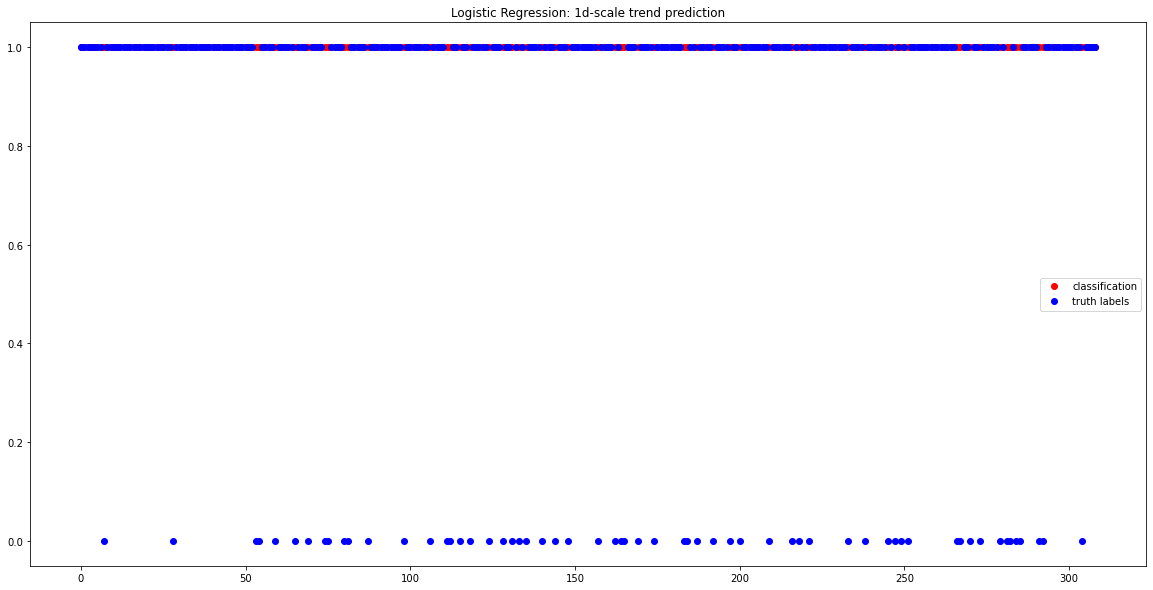

In [23]:
logi_clf_d = LogisticRegression(random_state=0).fit(X_train_d, y_train_d)

print('Accuracy of Logistic Regression (on 1d-scale data)')
print('training set accuracy:', logi_clf_d.score(X_train_d, y_train_d))
print('test set accuracy:', logi_clf_d.score(X_test_d, y_test_d))

plt.figure(figsize=(20,10))
plt.plot(np.arange(X_test_d.shape[0]), logi_clf_d.predict(X_test_d), 'ro', label = "classification")
plt.plot(np.arange(X_test_d.shape[0]), y_test_d, 'bo', label = "truth labels")
plt.title('Logistic Regression: 1d-scale trend prediction')
plt.legend()
plt.show()

According to the above results from `Ridge Classifier` & `Logistic Regression`, these **linear** models are working quite well on the price data.

The problem is that our dataset itself is skewed.. 80% or above consists of `True` labels for the `BUY` signal (whether we use `1h` scale or `1d` scale price data). We need to try training the classifiers using a dataset that consists of roughly 50% of `True` labels..